# Electromechanical System Identification - Overview

Example created by Wilson Rocha Lacerda Junior

> **Looking for more details on NARMAX models?**
> For comprehensive information on models, methods, and a wide range of examples and benchmarks implemented in SysIdentPy, check out our book:
> [*Nonlinear System Identification and Forecasting: Theory and Practice With SysIdentPy*](https://sysidentpy.org/book/0%20-%20Preface/)
>
> This book provides in-depth guidance to support your work with SysIdentPy.

More details about this data can be found in the following paper (in Portuguese): https://www.researchgate.net/publication/320418710_Identificacao_de_um_motorgerador_CC_por_meio_de_modelos_polinomiais_autorregressivos_e_redes_neurais_artificiais

In [ ]:
pip install sysidentpy

In [1]:
import numpy as np
import pandas as pd
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function import Polynomial
from sysidentpy.parameter_estimation import RecursiveLeastSquares
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)

In [2]:
df1 = pd.read_csv(
    "https://raw.githubusercontent.com/wilsonrljr/sysidentpy-data/refs/heads/main/datasets/generator/x_cc.csv"
)
df2 = pd.read_csv(
    "https://raw.githubusercontent.com/wilsonrljr/sysidentpy-data/refs/heads/main/datasets/generator/y_cc.csv"
)

<Axes: >

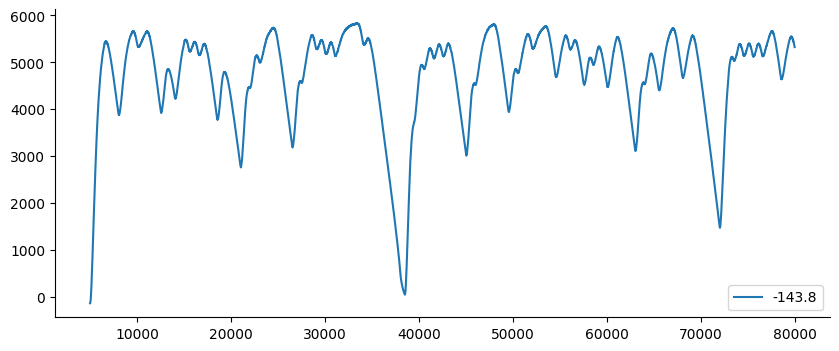

In [3]:
df2[5000:80000].plot(figsize=(10, 4))

In [4]:
# we will decimate the data using d=500 in this example
x_train, x_valid = np.split(df1.iloc[::500].values, 2)
y_train, y_valid = np.split(df2.iloc[::500].values, 2)

## Building a Polynomial NARX model

In [5]:
basis_function = Polynomial(degree=2)
estimator = RecursiveLeastSquares()

model = FROLS(
    order_selection=True,
    n_info_values=100,
    ylag=5,
    xlag=5,
    info_criteria="bic",
    estimator=estimator,
    basis_function=basis_function,
    err_tol=None,
)

C:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:618: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 66
  self.info_values = self.information_criterion(reg_matrix, y)


0.05681502501595064
        Regressors   Parameters             ERR
0           y(k-1)   1.5935E+00  9.86000310E-01
1        x1(k-1)^2   1.1202E+02  7.94813324E-03
2         y(k-2)^2  -1.7469E-05  2.50921747E-03
3    x1(k-1)y(k-1)  -1.5994E-01  1.43297462E-03
4           y(k-2)  -7.4013E-01  1.02774988E-03
5    x1(k-1)y(k-2)   1.0771E-01  5.35195948E-04
6     y(k-3)y(k-1)   4.2578E-05  3.46258211E-04
7        x1(k-4)^2  -6.1823E+00  6.91218347E-05
8    x1(k-1)y(k-3)  -3.0064E-02  2.83751722E-05
9     y(k-4)y(k-1)  -1.4505E-05  2.01620114E-05
10  x1(k-4)x1(k-1)  -2.7490E+00  1.09189469E-05
11    y(k-4)y(k-2)   7.2062E-06  1.27131624E-05
12   x1(k-5)y(k-1)  -8.5557E-04  6.53111914E-06
13  x1(k-3)x1(k-2)  -9.8645E-01  4.24331903E-06
14  x1(k-2)x1(k-1)  -2.3609E+00  6.41299982E-06
15         x1(k-3)  -2.0121E+02  6.43059002E-06
16   x1(k-1)y(k-5)   3.0338E-03  2.76577885E-06
17   x1(k-3)y(k-1)   3.2426E-02  2.79523223E-06
18   x1(k-4)y(k-1)   5.9510E-03  1.62218750E-06
19               1  

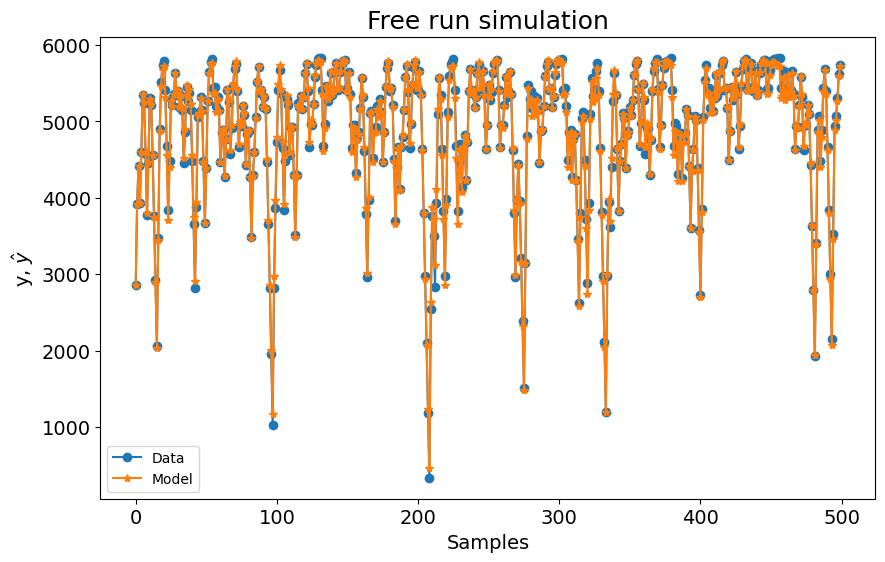

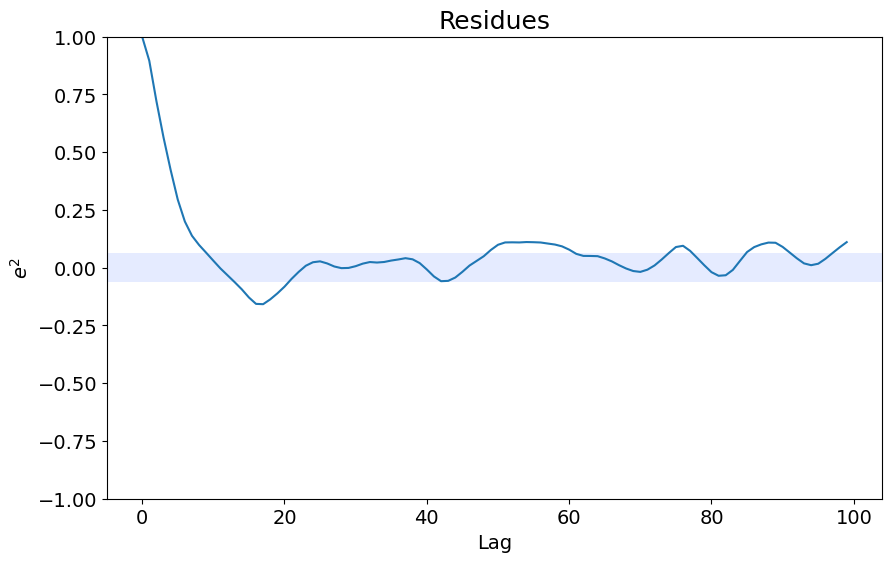

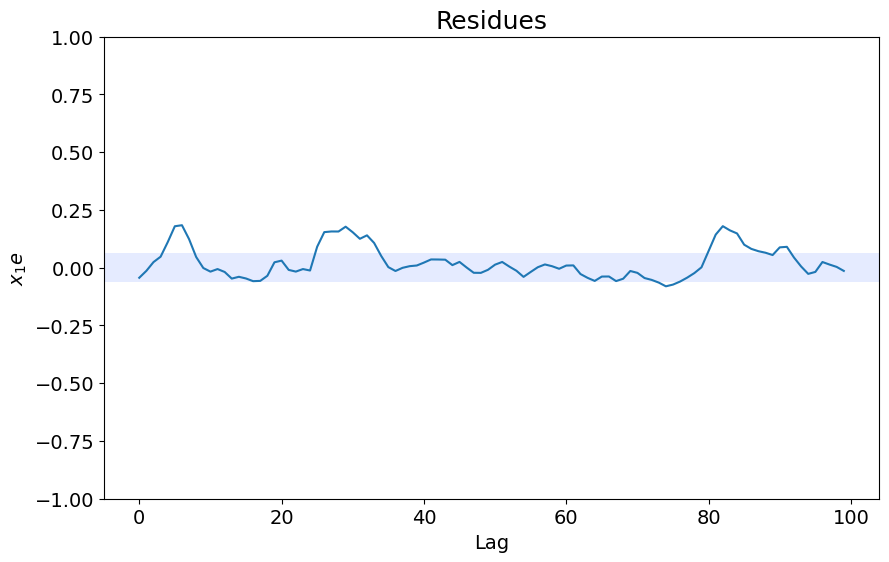

In [6]:
model.fit(X=x_train, y=y_train)
yhat = model.predict(X=x_valid, y=y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
print(rrse)

r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

plot_results(y=y_valid, yhat=yhat, n=1000)
ee = compute_residues_autocorrelation(y_valid, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_valid, yhat, x_valid)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

## Testing different autoregressive models

In [7]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor,
)
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, ARDRegression
from sysidentpy.general_estimators import NARX

basis_function = Polynomial(degree=2)
xlag = 5
ylag = 5

estimators = [
    (
        "KNeighborsRegressor",
        NARX(
            base_estimator=KNeighborsRegressor(),
            xlag=xlag,
            ylag=ylag,
            basis_function=basis_function,
            model_type="NARMAX",
        ),
    ),
    (
        "NARX-DecisionTreeRegressor",
        NARX(
            base_estimator=DecisionTreeRegressor(),
            xlag=xlag,
            ylag=ylag,
            basis_function=basis_function,
        ),
    ),
    (
        "NARX-RandomForestRegressor",
        NARX(
            base_estimator=RandomForestRegressor(n_estimators=200),
            xlag=xlag,
            ylag=ylag,
            basis_function=basis_function,
        ),
    ),
    (
        "NARX-Catboost",
        NARX(
            base_estimator=CatBoostRegressor(
                iterations=800, learning_rate=0.1, depth=8
            ),
            xlag=xlag,
            ylag=ylag,
            basis_function=basis_function,
            fit_params={"verbose": False},
        ),
    ),
    (
        "NARX-ARD",
        NARX(
            base_estimator=ARDRegression(),
            xlag=xlag,
            ylag=ylag,
            basis_function=basis_function,
        ),
    ),
    (
        "FROLS-Polynomial_NARX",
        FROLS(
            order_selection=True,
            n_info_values=50,
            ylag=xlag,
            xlag=ylag,
            info_criteria="bic",
            estimator=estimator,
            basis_function=basis_function,
            err_tol=None,
        ),
    ),
]

all_results = {}
for nome_do_modelo, modelo in estimators:
    all_results["%s" % nome_do_modelo] = []
    modelo.fit(X=x_train, y=y_train)
    yhat = modelo.predict(X=x_valid, y=y_valid)
    result = root_relative_squared_error(
        y_valid[modelo.max_lag :], yhat[modelo.max_lag :]
    )
    all_results["%s" % nome_do_modelo].append(result)
    print(nome_do_modelo, "%.3f" % np.mean(result))

KNeighborsRegressor 1.168
NARX-DecisionTreeRegressor 0.190
NARX-RandomForestRegressor 0.151
NARX-Catboost 0.121
NARX-ARD 0.083
FROLS-Polynomial_NARX 0.057


In [9]:
for model_name, metric in sorted(
    all_results.items(), key=lambda x: np.mean(x[1]), reverse=False
):
    print(model_name, np.mean(metric))

FROLS-Polynomial_NARX 0.05729765719062527
NARX-ARD 0.08336072971138789
NARX-Catboost 0.12137085298392238
NARX-RandomForestRegressor 0.15102205613876338
NARX-DecisionTreeRegressor 0.19018792321900427
KNeighborsRegressor 1.1676227184643708
